In [386]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import glob
from pathlib import Path

# Import Data

In [387]:
# # BRA_ABR_2019_02  BRA_ABR_2020_02  BRA_ABR_2021_05  BRA_ABR_2022_08  BRA_ABR_2023_09  
# Date = "BRA_ABR_2019_02"
# data_path = 'Data/'+Date+'/'
# file_pattern_dactyl = os.path.join(data_path, "D*.csv")
# csv_files_d = glob.glob(file_pattern_dactyl)
# file_pattern_sdactyl = os.path.join(data_path, "SD*.csv")
# csv_files_sd = glob.glob(file_pattern_sdactyl)
# csv_files = csv_files_d + csv_files_sd
# # csv_files = glob.glob('Data/'+Date+'/SU*.csv')

oiseau = "Dactyl/"
# BRA_ABR_2019_02  BRA_ABR_2020_02  BRA_ABR_2021_05  BRA_ABR_2022_08  BRA_ABR_2023_09  
path = "BRA_ABR_2022_08/"
# gap_threshold = 15  # SDAC in ABR 2019
# dur_seg = 10
gap_threshold = 90  # SDAC in ABR 2021, 2022, 2023 (je garde ça pour 2019 pour avoir la même fréquence)
dur_seg = 60
csv_files = glob.glob("Data_segmented/"+path+"by_dist/"+oiseau+"*.csv")

save_path = "Data_segmented_completed/"+path+"by_dist/"+oiseau  # Path to the folder where the segmented data will be stored

# Open each CSV file and store the data in a list
df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Visualisation

Trajectoires non complétées


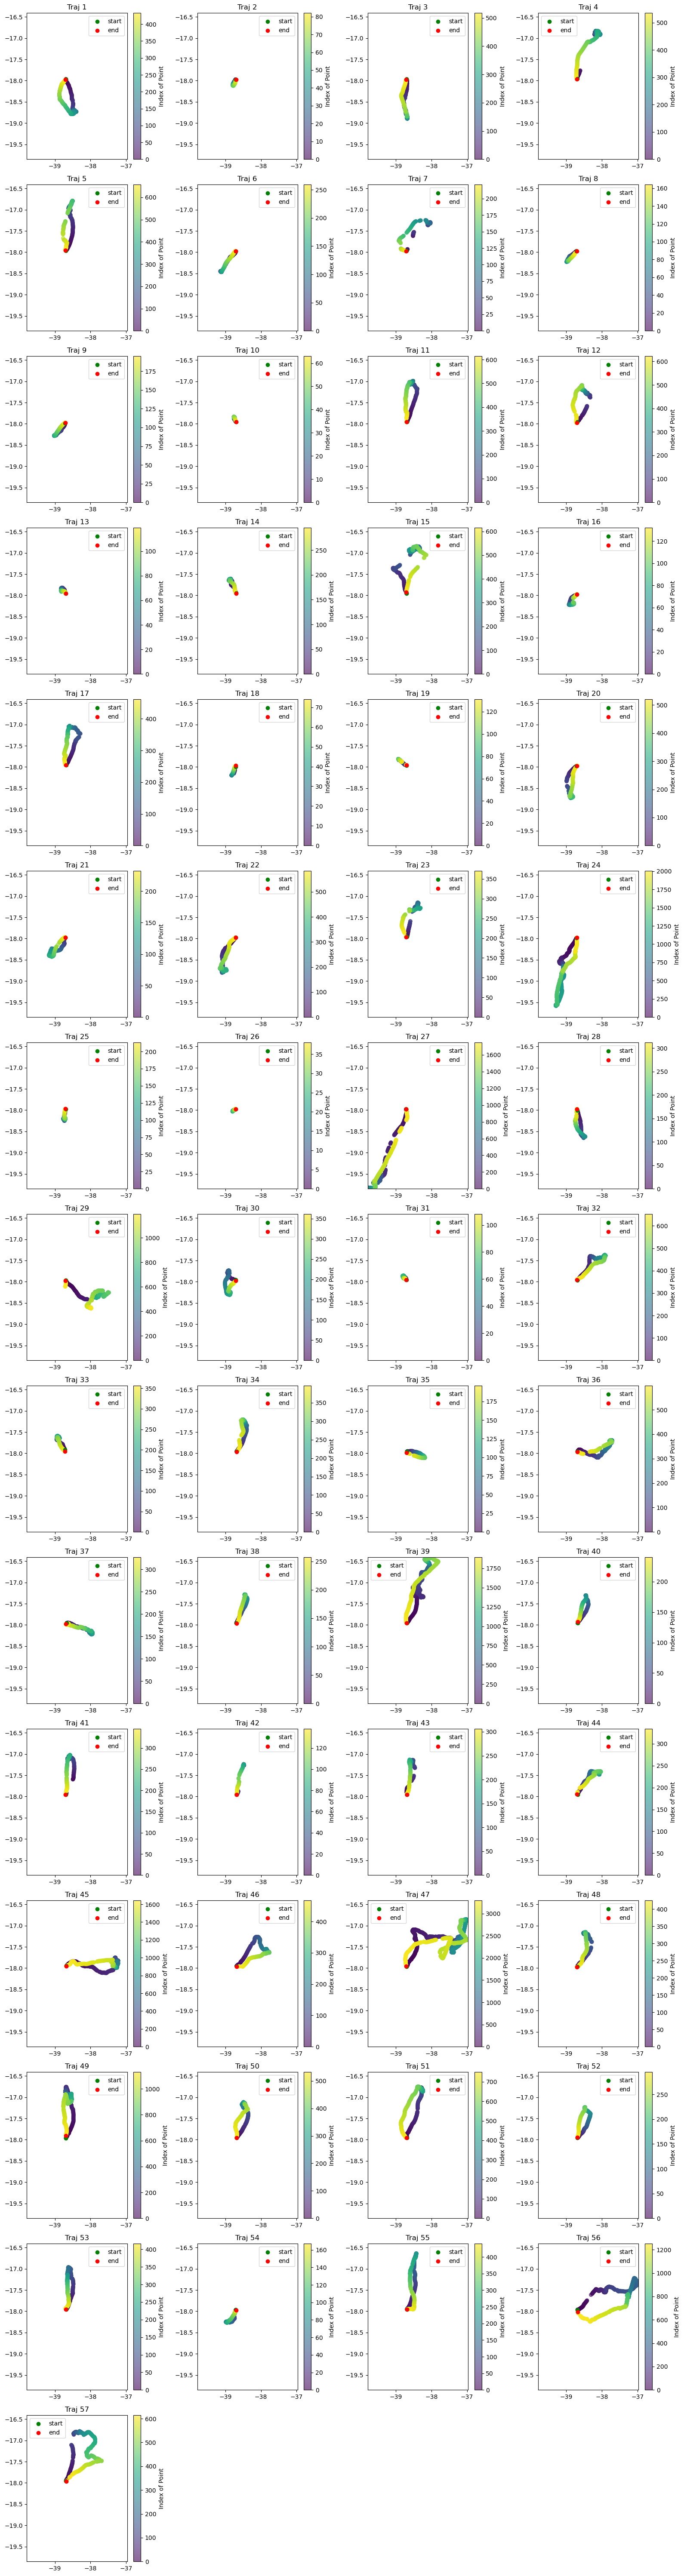

In [388]:
nb = len(df_list)
# nb = min(20, len(df_list))
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df['lon'].values for df in df_list]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df['lat'].values for df in df_list]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        indices = np.arange(len(df_list[i]['lon']))
        norm = plt.Normalize(indices.min(), indices.max())
        cmap = plt.get_cmap('viridis')
        colors = cmap(norm(indices))

        x = df_list[i]['lon']
        y = df_list[i]['lat']

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        
        # Add start and end points
        ax.scatter(x[0], y[0], color='green', label='start')
        ax.scatter(x.iloc[-1], y.iloc[-1], color='red', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')
        
        # Add colorbar to each subplot
        plt.colorbar(scatter, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires non complétées")
plt.tight_layout()
plt.show()

# Identification des trous

In [389]:
missing_segments = []

df_list_trous = [df.copy(deep= False) for df in df_list]

for i in range(len(df_list_trous)):
    df_list_trous[i]['datetime'] = pd.to_datetime(df_list_trous[i]['date'] + ' ' + df_list_trous[i]['time'], format='%d/%m/%Y %H:%M:%S.%f')
    df_list_trous[i].drop(columns=['date', 'time'], inplace=True)
    df_list_trous[i].sort_values('datetime', inplace=True)
    df_list_trous[i].reset_index(drop=True, inplace=True)
    df_list_trous[i]['time_diff'] = df_list_trous[i]['datetime'].diff().dt.total_seconds()
    
    # Identify missing segments based on gap threshold
    missing_segments_df = df_list_trous[i][df_list_trous[i]['time_diff'] > gap_threshold].copy()
    missing_segments_df['missing_duration'] = missing_segments_df['time_diff']  # Duration of the missing segment
    
    missing_segments.append(missing_segments_df)
    
    print(f"Traj {i+1} has {len(missing_segments[i])} missing segments")
    # print(missing_segments[i][['datetime', 'missing_duration']])

    stats = df_list_trous[i]['time_diff'].describe().loc[['min', '25%', '50%', '75%', 'max', 'mean']]
    # Print time difference statistics for the trajectory
    print(f"Time difference statistics for Traj {i+1}:")
    print(stats)

    # print(f"Time differences between consecutive points for Traj {i+1}:")
    # print(df_list_trous[i][['datetime', 'time_diff']])

# # Print lengths of missing segments for all trajectories
# for i, missing_segment in enumerate(missing_segments):
#     print(f"Missing segments for Traj {i+1}:")
#     for j, row in missing_segment.iterrows():
#         print(f"Segment {j+1}: Start - {row['datetime'] - pd.Timedelta(seconds=row['missing_duration'])}, "
#               f"End - {row['datetime']}, Duration - {row['missing_duration']} seconds")


Traj 1 has 6 missing segments
Time difference statistics for Traj 1:
min      16.00000
25%      60.00000
50%      60.00000
75%      60.00000
max     457.00000
mean     63.73903
Name: time_diff, dtype: float64
Traj 2 has 1 missing segments
Time difference statistics for Traj 2:
min     27.0
25%     59.0
50%     60.0
75%     61.0
max     92.0
mean    60.0
Name: time_diff, dtype: float64
Traj 3 has 8 missing segments
Time difference statistics for Traj 3:
min      26.000000
25%      59.000000
50%      60.000000
75%      61.000000
max     537.000000
mean     64.410058
Name: time_diff, dtype: float64
Traj 4 has 7 missing segments
Time difference statistics for Traj 4:
min        15.000000
25%        59.000000
50%        60.000000
75%        61.000000
max     14407.000000
mean       90.734579
Name: time_diff, dtype: float64
Traj 5 has 13 missing segments
Time difference statistics for Traj 5:
min       19.000000
25%       59.000000
50%       60.000000
75%       61.000000
max     2440.000000


In [390]:
for i, df in enumerate(df_list_trous): 
    # Interpolation des points manquants avec un intervalle fixe de dur_seg secondes
    df = df.drop(columns=['time_diff'])

    index = pd.DatetimeIndex(df['datetime'])
    df.index = index
    df = df[~df.index.duplicated(keep='first')]
    df_inferred = df.infer_objects(copy=False)

    numeric_cols = df_inferred.select_dtypes(include=[np.number]).columns
    df_inferred = df_inferred[numeric_cols]
    
    new_index = pd.date_range(start=index[0], end=index[-1], freq=f'{dur_seg}s')
    new_index_full = new_index.union(index)
    df_inferred = df_inferred.reindex(new_index_full)
    df_inferred = df_inferred.interpolate(method='time').round(2)
    df_interpolated = df_inferred.reset_index(drop=True)
    df_interpolated.index = new_index_full
    df_interpolated = df_interpolated.loc[new_index]
 
    # Affichage des résultats pour le trajet traité
    print(f"Trajet {i+1} avec interpolation des points manquants :")
    print(df_interpolated)
    
    # Remplacer les segments manquants dans df_list_trous par les DataFrame interpolés
    df_list_trous[i] = df_interpolated

Trajet 1 avec interpolation des points manquants :
                       ax    ay    az  pressure  temperature    lat    lon  \
2022-09-23 13:41:01  0.00 -0.19  0.75    993.69        32.30 -17.96 -38.69   
2022-09-23 13:42:01  0.18 -0.19  1.11    994.22        32.20 -17.97 -38.69   
2022-09-23 13:43:01 -0.18 -0.19  0.39   1000.01        32.35 -17.97 -38.68   
2022-09-23 13:44:01  0.19 -0.19  1.31   1018.27        29.60 -17.98 -38.68   
2022-09-23 13:45:01  0.19 -0.19  0.91   1016.63        29.45 -17.99 -38.68   
...                   ...   ...   ...       ...          ...    ...    ...   
2022-09-23 21:16:01  0.56  0.19  2.06    999.32        27.80 -17.99 -38.71   
2022-09-23 21:17:01  0.38  0.00  1.50    999.33        27.50 -17.99 -38.71   
2022-09-23 21:18:01  0.56 -0.00  1.31    998.60        27.50 -17.98 -38.70   
2022-09-23 21:19:01  0.19 -0.19  1.12    998.04        27.50 -17.98 -38.70   
2022-09-23 21:20:01  0.01 -0.02  1.14    997.58        27.40 -17.98 -38.70   

            

# Nouvelle visu et analyse

In [391]:
missing_segments = []

for i in range(len(df_list_trous)):
    df_list_trous[i]['datetime'] = pd.to_datetime(df_list_trous[i].index)
    df_list_trous[i]['time_diff'] = df_list_trous[i]['datetime'].diff().dt.total_seconds()
    
    missing_segments_df = df_list_trous[i][df_list_trous[i]['time_diff'] > gap_threshold].copy()
    missing_segments_df['missing_duration'] = missing_segments_df['time_diff']  # Duration of the missing segment
    missing_segments.append(missing_segments_df)

    print(f"Traj {i+1} has {len(missing_segments[i])} missing segments")
    # print(missing_segments[i][['datetime', 'missing_duration']])

    stats = df_list_trous[i]['time_diff'].describe().loc[['min', '25%', '50%', '75%', 'max', 'mean']]
    # Print time difference statistics for the trajectory
    print(f"Time difference statistics for Traj {i+1}:")
    print(stats)

Traj 1 has 0 missing segments
Time difference statistics for Traj 1:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 2 has 0 missing segments
Time difference statistics for Traj 2:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 3 has 0 missing segments
Time difference statistics for Traj 3:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 4 has 0 missing segments
Time difference statistics for Traj 4:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64


Traj 5 has 0 missing segments
Time difference statistics for Traj 5:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 6 has 0 missing segments
Time difference statistics for Traj 6:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 7 has 0 missing segments
Time difference statistics for Traj 7:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 8 has 0 missing segments
Time difference statistics for Traj 8:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 9 has 0 missing segments
Time difference statistics for Traj 9:
min     60.0
25%     60.0
50%     60.0
75%     60.0
max     60.0
mean    60.0
Name: time_diff, dtype: float64
Traj 10 has 0 missing segments
Time difference statistics for Traj 10:
min     60.0
25%     60.0
50%     

C:\Users\julie\AppData\Local\Temp\ipykernel_36956\2929031504.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(x[0], y[0], color='green', label='start')


Trajectoires complétées


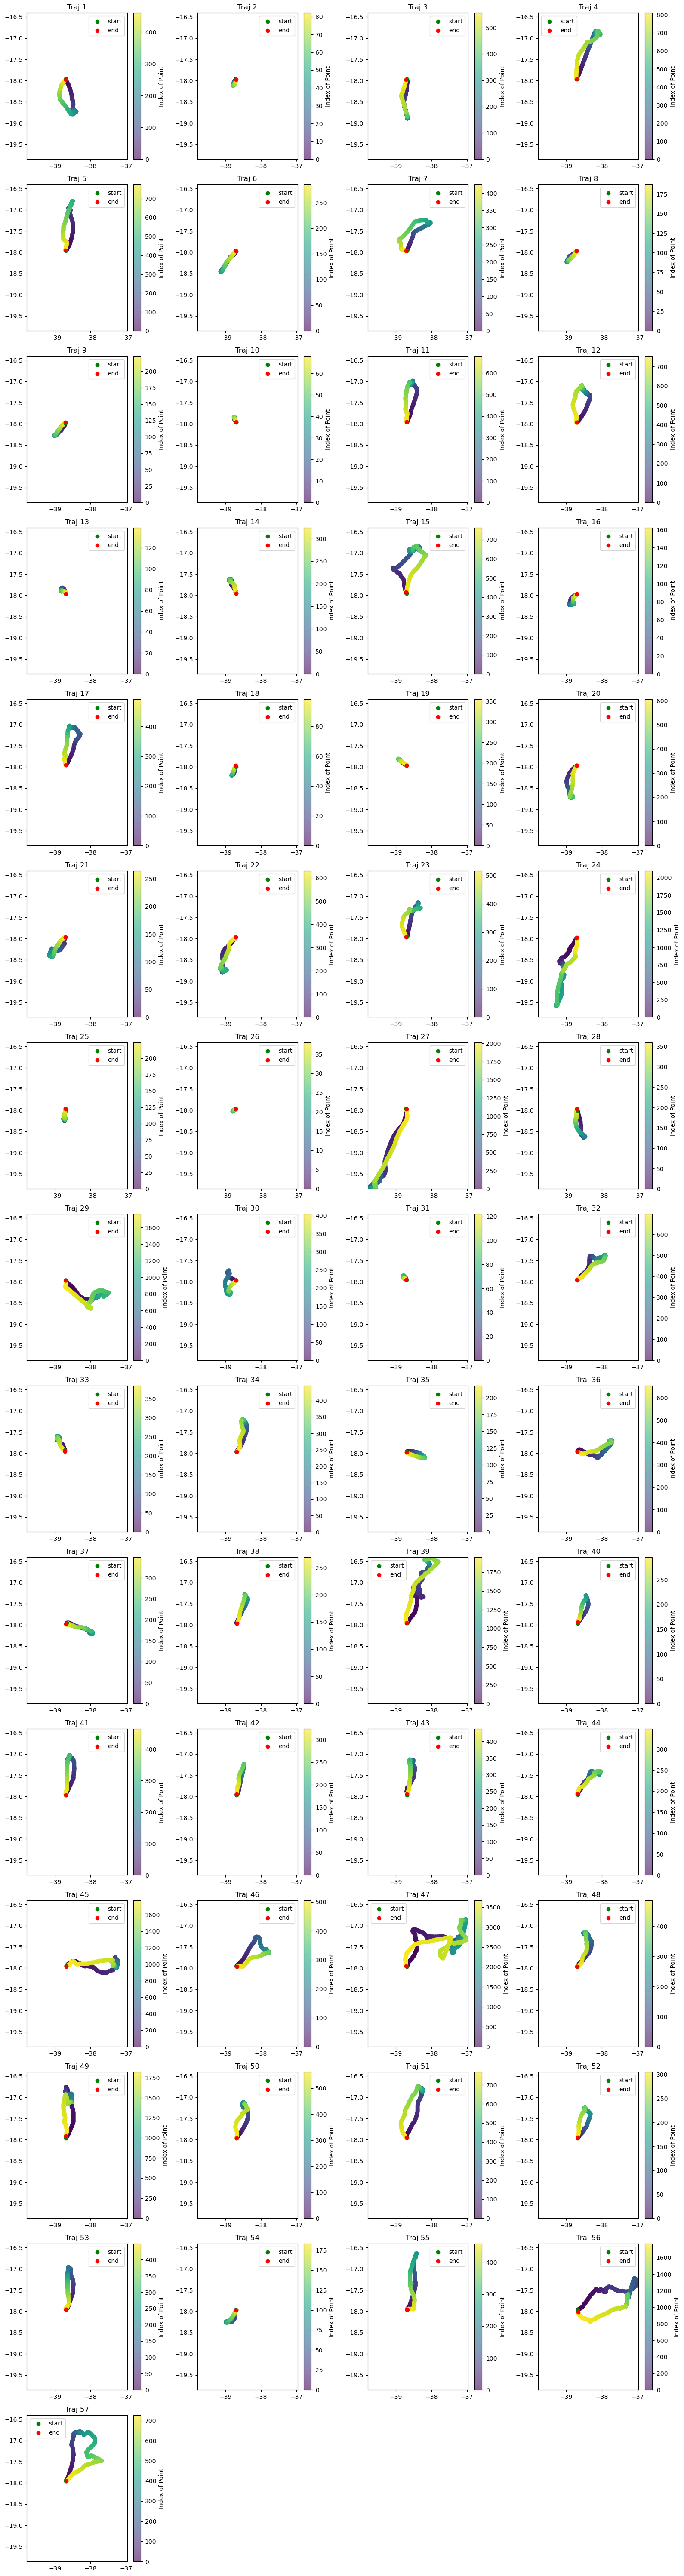

In [392]:
nb = len(df_list_trous)
# nb = min(20, len(df_list_trous))
num_cols = 4
num_rows = int(np.ceil(nb / num_cols))

# Calculate the size of each subplot
subplot_size = 4
fig_width = num_cols * subplot_size
fig_height = num_rows * subplot_size

lon_arrays = [df['lon'].values for df in df_list_trous]
lon_concatenated = np.concatenate(lon_arrays)
x_min = np.min(lon_concatenated)
x_max = np.max(lon_concatenated)

lat_arrays = [df['lat'].values for df in df_list_trous]
lat_concatenated = np.concatenate(lat_arrays)
y_min = np.min(lat_concatenated)
y_max = np.max(lat_concatenated)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


# Plot each trajectory
for i, ax in enumerate(axs.flatten()):
    if i < nb:
        indices = np.arange(len(df_list_trous[i]['lon']))
        norm = plt.Normalize(indices.min(), indices.max())
        cmap = plt.get_cmap('viridis')
        colors = cmap(norm(indices))

        x = df_list_trous[i]['lon']
        y = df_list_trous[i]['lat']

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        scatter = ax.scatter(x, y, c=indices, cmap='viridis', marker='o', alpha=0.6)
        
        # Add start and end points
        ax.scatter(x[0], y[0], color='green', label='start')
        ax.scatter(x.iloc[-1], y.iloc[-1], color='red', label='end')

        ax.set_title(f'Traj {i+1}')
        ax.legend(loc='best')
        
        # Add colorbar to each subplot
        plt.colorbar(scatter, ax=ax, label='Index of Point')
    else:
        ax.axis('off')  # Hide empty subplots

print("Trajectoires complétées")
plt.tight_layout()
plt.show()

# Sauvegarde des nouvelles traj corrigées

In [393]:
if os.path.exists(save_path):
    shutil.rmtree(save_path)
Path(save_path).mkdir(parents=True, exist_ok=True)

i = 1
for df in df_list_trous:
    filename = f""+save_path+"data_seg_compl_"+str(i)+".csv"
    df.to_csv(filename, index=False)
    i += 1


## 